In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
from sciann import Functional, Variable, SciModel, PDE
from sciann.utils import *
import scipy.io 
import time
import random
from scipy import interpolate
from scipy import ndimage
from scipy.interpolate import griddata

from eikonalfm import factored_fast_marching as ffm
from eikonalfm import distance
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

2024-07-10 21:54:47.217586: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-10 21:54:47.350832: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-10 21:54:47.382217: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-10 21:54:47.860401: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

---------------------- SCIANN 0.7.0.0 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.10.1 
Python Version: 3.8.16 (default, Jun 12 2023, 18:09:05) 
[GCC 11.2.0] 

Outdated SciANN installation is found (V-0.7.0.0). Get the latest version (V-0.7.0.1):  
      > pip [--user] install --upgrade sciann  


In [2]:
tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[0], 'GPU')
for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
np.random.seed(123)
tf.random.set_seed(123)

In [4]:
ymin = 0.; ymax = 3; deltay = 0.025;
xmin = 0.; xmax = 4; deltax = 0.025;
zmin = 0.; zmax = 2.05; deltaz = 0.025;


# sz = 0.
# sx = np.round(np.arange(0,4.01,0.25),2); 
# sy = np.round(np.arange(0,3.01,0.25),2);

mat_data = scipy.io.loadmat('./3Dvelocity/velocity_3d.mat')
vp = mat_data['v']
vs = vp/1.731

nz = vp.shape[0]
nx = vp.shape[1]
ny = vp.shape[2]


In [5]:
#jianboqi
iz = 0.
ix = np.round(np.arange(0,4.01,0.2),2); 
iy = np.round(np.arange(0,3.01,0.2),2);
sdata = np.load('random_coordinates.npz')
sx = sdata['rx']
sy = sdata['ry']
sz = sdata['rz']

In [6]:
ssx,ssy = np.meshgrid(ix,iy,indexing='ij')
ssx = ssx.reshape(-1,1)
ssy = ssy.reshape(-1,1)

In [7]:
iX,iY,rssz= np.meshgrid(ix,iy,sz,indexing='ij')
iX,iY,rssx= np.meshgrid(ix,iy,sx,indexing='ij')
iX,iY,rssy= np.meshgrid(ix,iy,sy,indexing='ij')
ss = [iX.reshape(-1,1),iY.reshape(-1,1)]
rssz = rssz.reshape(-1,1)
rssx = rssx.reshape(-1,1)
rssy = rssy.reshape(-1,1)

In [8]:
num = 500000
rx = np.round(np.random.uniform(xmin, xmax, num), 4).reshape(-1,1)
ry = np.round(np.random.uniform(ymin, ymax, num), 4).reshape(-1,1)
rz = np.round(np.random.uniform(zmin, zmax, num), 4).reshape(-1,1)
rsx = np.round(np.random.uniform(xmin, xmax, num), 4).reshape(-1,1)
rsy = np.round(np.random.uniform(ymin, ymax, num), 4).reshape(-1,1)
rsz = np.round(np.random.uniform(zmin, zmax, num), 4).reshape(-1,1)

In [9]:
rx = np.append(rx,ss[0])  
ry = np.append(ry,ss[1])
rz = np.append(rz,np.zeros(ss[0].shape))
rsz = np.append(rsz, rssz)
rsx = np.append(rsx, rssx)
rsy = np.append(rsy, rssy)

In [10]:
Rq = np.sqrt((rz-rsz)**2 + (rx-rsx)**2 + (ry-rsy)**2); 
px1q = np.divide(rx-rsx, Rq, out=np.zeros_like(Rq),where=Rq!=0)
pz1q = np.divide(rz-rsz, Rq, out=np.zeros_like(Rq),where=Rq!=0)
py1q = np.divide(ry-rsy, Rq, out=np.zeros_like(Rq),where=Rq!=0)

In [11]:
indices = np.arange(len(rx) -ss[0].size  , len(rx))
index = np.where(np.isin(np.arange(len(rx)), indices))[0]

print(index.shape)

(16800,)


In [12]:
Tp_data=np.load('Tp_suiji.npy')
Ts_data=np.load('Ts_suiji.npy')

In [13]:
x_n = (ssx / deltax).astype(int)
y_n = (ssy / deltay).astype(int)

Tp_list = []
Ts_list = []

for rx_, ry_ in zip(x_n, y_n):
    Tp_list.append(Tp_data[0,rx_,ry_,:])
    Ts_list.append(Ts_data[0,rx_,ry_,:])
    
Tp = np.array(Tp_list)
Tp = Tp.reshape(-1,1)

Ts = np.array(Ts_list)
Ts = Ts.reshape(-1,1)

In [14]:
K.clear_session()

hidden_layers = 8*[64]
hidden_layers2 = 8*[32]

xt = Variable("xt", dtype='float64')
zt = Variable("zt", dtype='float64')
yt = Variable("yt", dtype='float64')
sxt = Variable("sxt", dtype='float64')
syt = Variable("syt", dtype='float64')
szt = Variable("szt", dtype='float64')
px1t = Variable("px1t", dtype='float64')
pz1t = Variable("pz1t", dtype='float64')
py1t = Variable("py1t", dtype='float64')
Rt = Variable("Rt", dtype='float64')

taup, taus = Functional(['taup','taus'], [zt, xt, yt, szt, sxt, syt], hidden_layers, 'l-elu','sigmoid')
vp, vs = Functional(['vp','vs'], [zt, xt, yt], hidden_layers2, 'l-elu','sigmoid')

taup = taup
taus = taus
vp = vp*6.0
vs = vs*4.0

Lp = (Rt * diff(taup, xt) + taup * px1t) ** 2 + (Rt * diff(taup, zt) + taup * pz1t) ** 2 + (Rt * diff(taup, yt) + taup * py1t) ** 2 - 1.0 / vp ** 2 
Ls = (Rt * diff(taus, xt) + taus * px1t) ** 2 + (Rt * diff(taus, zt) + taus * pz1t) ** 2 + (Rt * diff(taus, yt) + taus * py1t) ** 2 - 1.0 / vs ** 2

imposed_ids = index
imposed_taup = (Tp[index-num]).reshape(-1,1)
imposed_taus = (Ts[index-num]).reshape(-1,1)

targets = [taup*Rt, taus*Rt, Lp, Ls]
target_vals = [(imposed_ids, imposed_taup),(imposed_ids, imposed_taus),'zeros','zeros']

model = SciModel(
    [zt, xt, yt, szt, sxt, syt, pz1t, px1t, py1t, Rt],
    targets
)

In [15]:
epoch_num = 200
start_time = time.time()
hist = model.train(
    [rz, rx, ry, rsz, rsx, rsy, pz1q, px1q, py1q, Rq],
    target_vals,
    batch_size=5000,
    epochs=epoch_num,
    learning_rate=0.005,
    verbose=2,
)

elapsed = time.time() - start_time
print('Training time: %.2f minutes' % (elapsed / 60.))


Total samples: 516800 
Batch size: 5000 
Total batches: 104 



2024-07-10 21:54:52.540804: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-10 21:54:53.100752: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 45581 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:73:00.0, compute capability: 8.6
2024-07-10 21:54:53.137610: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


Epoch 1/2000
104/104 - 7s - loss: 0.0496 - mul_14_loss: 0.0262 - mul_15_loss: 0.0235 - sub_loss: 0.0024 - sub_1_loss: 0.0070 - lr: 0.0050 - time: 7.0229 - 7s/epoch - 68ms/step
Epoch 2/2000
104/104 - 3s - loss: 0.0018 - mul_14_loss: 3.2159e-04 - mul_15_loss: 0.0011 - sub_loss: 5.7217e-05 - sub_1_loss: 3.7195e-04 - lr: 0.0050 - time: 3.2655 - 3s/epoch - 31ms/step
Epoch 3/2000
104/104 - 3s - loss: 0.0013 - mul_14_loss: 2.6417e-04 - mul_15_loss: 8.4078e-04 - sub_loss: 3.0223e-05 - sub_1_loss: 1.8633e-04 - lr: 0.0050 - time: 3.2456 - 3s/epoch - 31ms/step
Epoch 4/2000
104/104 - 3s - loss: 0.0014 - mul_14_loss: 2.7181e-04 - mul_15_loss: 8.6687e-04 - sub_loss: 2.8548e-05 - sub_1_loss: 1.9401e-04 - lr: 0.0050 - time: 3.1724 - 3s/epoch - 31ms/step
Epoch 5/2000
104/104 - 3s - loss: 0.0011 - mul_14_loss: 2.2252e-04 - mul_15_loss: 6.6796e-04 - sub_loss: 2.4105e-05 - sub_1_loss: 1.4692e-04 - lr: 0.0050 - time: 3.1520 - 3s/epoch - 30ms/step
Epoch 6/2000
104/104 - 3s - loss: 0.0010 - mul_14_loss: 2.25

In [16]:
model.save_weights('pinntomo_over3d_new.h5')

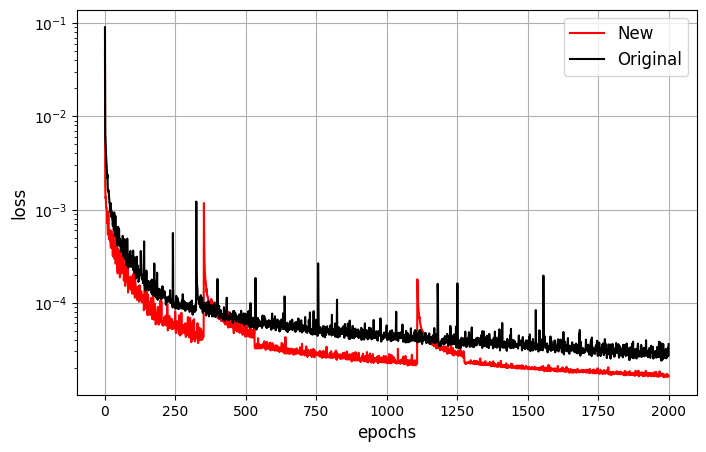

In [17]:
loss_tomo_new = hist.history['loss']
np.save('./loss_tomo_over_random_new_sparse%d.npy'%(epoch_num),loss_tomo_new)


loss_tomo_ori = np.load('./loss_tomo_over_random_ori_sparse%d.npy'%(epoch_num))

plt.style.use('default')

plt.figure(figsize=(8,5))

ax = plt.gca()
plt.semilogy(loss_tomo_new[::1],'r')
plt.semilogy(loss_tomo_ori[::1],'k')

plt.xlabel('epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(['New','Original'], fontsize=12)
plt.grid()
# plt.savefig("./Fig/over3d_loss_sparse.jpeg", format='jpeg', bbox_inches="tight",dpi=400)